In [1]:
%run RD_HERS_HETDEX_base_functions.ipynb

In [2]:
def get_twod_ifft(map_one, map_two=None, pix_arcsec=False):
    dims = np.shape(map_one)
    if pix_arcsec:
        fac = (pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])
    else:
        fac = 1
        
    if map_two is None:
        return np.real(np.fft.ifft2(map_one)*np.conj(np.fft.ifft2(map_one))) * fac
    else:
        return np.real(np.fft.ifft2(map_one)*np.conj(np.fft.ifft2(map_two))) * fac    

In [3]:
def get_twod_fft(map_one, map_two=None, pix_arcsec=False):
    dims = np.shape(map_one)
    if pix_arcsec:
        fac = (pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])
    else:
        fac = 1
        
    if map_two is None:
        return np.real(np.fft.fft2(map_one)*np.conj(np.fft.fft2(map_one))) * fac
    else:
        return np.real(np.fft.fft2(map_one)*np.conj(np.fft.fft2(map_two))) * fac        

In [4]:
path_hers_maps = os.path.join(os.environ['MAPSPATH'],'Herschel','SPT')

hers_maps = {'combined':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PLW'
             }, 
             'jk1':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PLW'
             }, 
             'jk2':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PLW'
             }, 
            }

In [5]:
class MapObject():
    maps={}
    masks={}
    headers={}
    pix_sizes_arcsec={}
    def __init__(self, base_path, jack_dict):
        for jack, map_dict in jack_dict.items():
            self.maps[jack]={}
            self.masks[jack]={}
            self.headers[jack]={}
            self.pix_sizes_arcsec[jack]={}
            for key, map_name in map_dict.items():
                map_path = os.path.join(base_path, map_name+'.fits')
                try:
                    map_in, hd_in = fits.getdata(map_path, 0, header=True)
                except:
                    map_in, hd_in = fits.getdata(map_path, 1, header=True)
                try:
                    pix_arcsec = hd_in['CDELT2']*3600
                except:
                    pix_arcsec = hd_in['CD2_2']*3600  
                self.maps[jack][key] = map_in
                self.headers[jack][key] = hd_in
                self.pix_sizes_arcsec[jack][key] = pix_arcsec

                mask_in=np.ones_like(map_in)
                mask_in[np.isnan(map_in)]=0
                map_in[np.isnan(map_in)]=0
                self.masks[jack][key] = mask_in

In [6]:
hers_obj = MapObject(path_hers_maps, hers_maps)

In [7]:
name='PSW'
hers = hers_obj.maps['combined'][name]
hers_mask = hers_obj.masks['combined'][name]
hers_mask_jk1 = hers_obj.masks['jk1'][name]
hers_mask_jk2 = hers_obj.masks['jk2'][name]
hd_hers = hers_obj.headers['combined'][name]
pix_arcsec = hers_obj.pix_sizes_arcsec['combined'][name]
print('pixel size = {0:0.2f} arcsec'.format(pix_arcsec))
dims = np.shape(hers_mask_jk1)
fsky = (np.product(dims) * (pix_arcsec / 3600 / 180 * np.pi)**2) / (4 * np.pi)
deltal = 120 # get_map_native_deltal(hers, pix_arcsec)
width=0.95
print('delta ell = {0:0.2f}'.format(deltal))

pixel size = 15.00 arcsec
delta ell = 120.00


(2976, 3228)


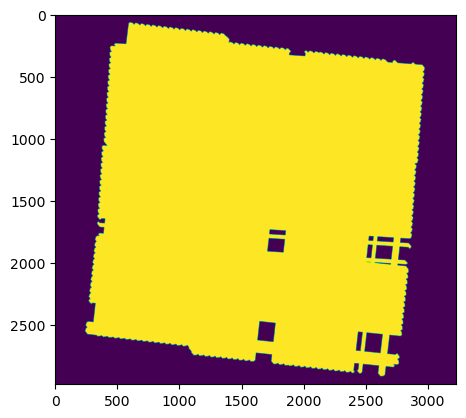

In [8]:
plt.imshow(hers_mask_jk1);
print(np.shape(hers_mask_jk1))

(2976, 3228)


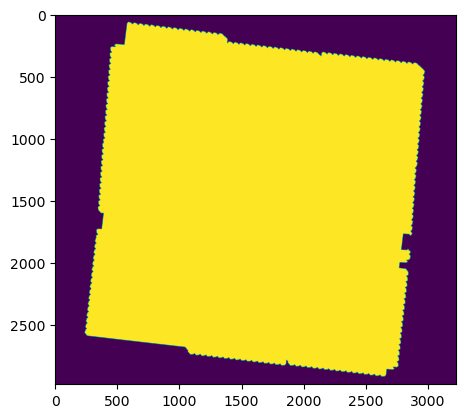

In [9]:
plt.imshow(hers_mask_jk2);
print(np.shape(hers_mask_jk2))

In [10]:
k_psw=get_k_from_map(hers,pix_arcsec)

(2976, 3228)


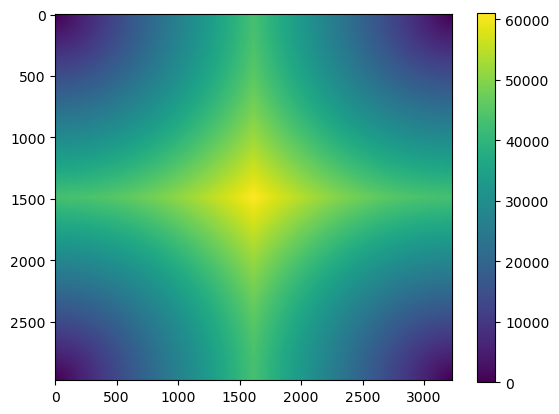

In [11]:
plt.imshow(k_psw);
plt.colorbar();
print(np.shape(k_psw))

# Test recovery of input power spetrum

In [12]:
print(pix_arcsec)
print(deltal)

15.000000782328
120


In [13]:
def shift_twod(seq, x, y):
    out = np.roll(np.roll(seq, int(x), axis=1), int(y), axis=0)
    return out

In [24]:
def get_mc_mkk(mask_one, mask_two, pix_arcsec, deltal=None, width=None, nomask=False):
    shape_map = np.shape(mask_one)
    k_map=get_k_from_map(mask_one, pix_arcsec)
    ell_bins = get_ell_bins(mask_one, pix_arcsec, deltal=deltal, width=width)
    npk = len(ell_bins[:-1])
    pk = np.zeros([npk,npk])
    ell = np.zeros_like(pk)
    for iell in range(npk):
        idx_ring = (k_map >= ell_bins[iell]) & (k_map < ell_bins[iell+1])
        idx_not_ring = (k_map < ell_bins[iell]) | (k_map >= ell_bins[iell+1])
        imap_ring = np.ones_like(mask_one)*np.random.normal(size=shape_map)
        imap_ring[idx_not_ring]=0
        
        imode_map = (np.real(np.fft.ifft2(imap_ring))+np.imag(np.fft.ifft2(imap_ring)))
        if nomask:
            imask_mkk = get_twod_fft(imode_map, map_two=None, pix_arcsec=None)
        else:
            #imask_mkk = get_twod_fft(imode_map * mask_one, map_two=imode_map * mask_two, pix_arcsec=pix_arcsec)
            imask_mkk = get_twod_fft(imode_map * mask_one, map_two=imode_map * mask_two, pix_arcsec=None)
        pdb.set_trace()
        ipk_mask, ipk_ell = bin_in_rings(imask_mkk, ell_bins, k_map)
        pk[iell] = ipk_mask
        ell[iell] = np.mean(k_map[idx_ring])
    return ell_bins, pk

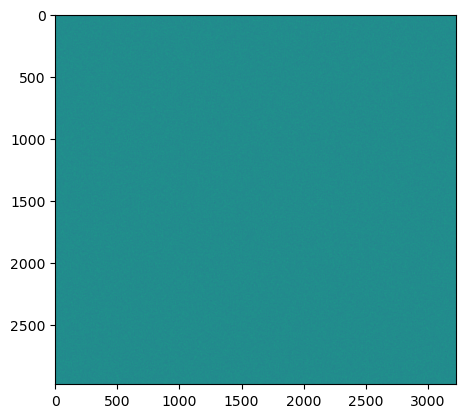

In [28]:
dims = np.shape(hers_mask_jk1)
imap_ring = np.ones_like(hers_mask_jk1)*np.random.normal(size=dims)
imode_map = (np.real(np.fft.ifft2(imap_ring))+np.imag(np.fft.ifft2(imap_ring)))
plt.imshow(imode_map);

> c:\users\viero\appdata\local\temp\ipykernel_27132\2623272723.py(21)get_mc_mkk()

ipdb> imask_mkk
array([[ 1.28837712e-01,  7.22739708e-02,  8.36482564e-02, ...,
         5.97215700e-01,  8.36482564e-02,  7.22739708e-02],
       [ 3.13585403e-01,  4.08387359e-01,  1.57457482e-01, ...,
         2.26429486e+00,  1.04811817e+00,  1.06768628e-01],
       [ 4.50710867e-03,  3.85113386e-01,  9.82061494e-01, ...,
         2.20081170e-01, -9.48565110e-04,  1.33451716e+00],
       ...,
       [ 5.56437585e-01,  1.43390381e+00,  5.06233230e-01, ...,
         5.74997272e-01,  1.38165748e-01,  1.55599569e-01],
       [ 4.50710867e-03,  1.33451716e+00, -9.48565110e-04, ...,
         1.48064130e-01,  9.82061494e-01,  3.85113386e-01],
       [ 3.13585403e-01,  1.06768628e-01,  1.04811817e+00, ...,
         8.70922246e-02,  1.57457482e-01,  4.08387359e-01]])
ipdb> plt.imshow(imode_map)
ipdb> plt.show()


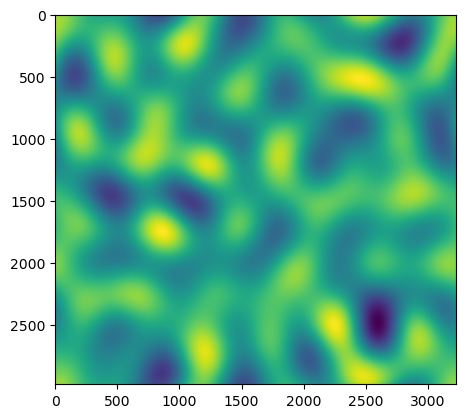

ipdb> imode_map
array([[1.89735408e-06, 1.89952173e-06, 1.90158748e-06, ...,
        1.89023963e-06, 1.89271302e-06, 1.89508451e-06],
       [1.90092686e-06, 1.90308155e-06, 1.90513404e-06, ...,
        1.89384946e-06, 1.89631081e-06, 1.89866994e-06],
       [1.90445954e-06, 1.90660093e-06, 1.90863983e-06, ...,
        1.89742026e-06, 1.89986921e-06, 1.90221563e-06],
       ...,
       [1.88639783e-06, 1.88860229e-06, 1.89070575e-06, ...,
        1.87917852e-06, 1.88168592e-06, 1.88409237e-06],
       [1.89008930e-06, 1.89228184e-06, 1.89437306e-06, ...,
        1.88290390e-06, 1.88540031e-06, 1.88779545e-06],
       [1.89374147e-06, 1.89592174e-06, 1.89800040e-06, ...,
        1.88659102e-06, 1.88907610e-06, 1.89145959e-06]])
ipdb> iell
0
ipdb> ell_bins
array([   60.        ,   180.        ,   537.36887141,  1604.25168864,
        4789.30510764, 14297.90822504])
ipdb> np.sum(idx_ring)
116
ipdb> plt.imshow(imap_ring)
ipdb> plt.show()


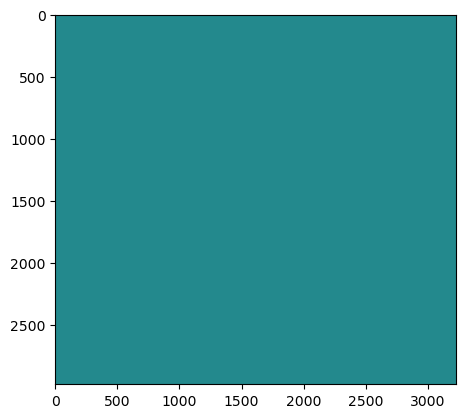

ipdb> imap_ring
array([[ 0.        ,  0.        ,  0.        , ...,  1.30181057,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.26922399, ..., -1.04984289,
        -1.51885738,  0.        ],
       [ 0.        ,  0.3528528 , -1.17003024, ...,  0.51458494,
         0.689593  ,  1.56202316],
       ...,
       [-0.97817945,  2.42653292,  1.20780349, ...,  0.3614077 ,
        -0.99835674, -0.17694404],
       [ 0.        , -1.20430496,  0.48892082, ..., -0.17241708,
         0.94287304,  1.2160913 ],
       [ 0.        ,  0.        ,  0.57946789, ...,  0.76452177,
         0.83618634,  0.        ]])
ipdb>  max(imap_ring)
*** ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
ipdb>  np.max(imap_ring)
2.5353440615143716
ipdb> np.min(imap_ring)
-2.258565530735462
ipdb> shape_map
(2976, 3228)
ipdb> c
> c:\users\viero\appdata\local\temp\ipykernel_27132\2623272723.py(21)get_mc_mkk()

ipdb> plt.imshow(imode_map)
ipdb> 

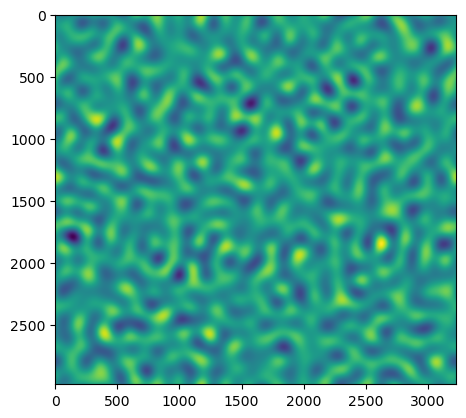

ipdb> exit


In [25]:
#deltal=100
#width = 1.0
#ell_bins = get_ell_bins(hers_mask_jk1, pix_arcsec, deltal=deltal, width=width)
tst_ell, tst_pk_nomask = get_mc_mkk(hers_mask_jk1, hers_mask_jk2, pix_arcsec, deltal=deltal, width=width, nomask=False)

In [20]:
print(deltal)
print(width)
print(tst_ell)

120
0.95
[   60.           180.           537.36887141  1604.25168864
  4789.30510764 14297.90822504]


In [18]:
tst_pk_nomask

array([[ 6.80057792e-01,  5.77266563e-03,  5.20855645e-05,
         8.19310721e-07, -4.36416782e-09],
       [ 6.37175493e-02,  6.42470449e-01,  2.83757096e-03,
         7.70544514e-06, -4.27927533e-08],
       [ 5.74903332e-03,  2.34282520e-02,  6.17599698e-01,
         8.96081114e-04, -2.90257204e-07],
       [ 1.54878579e-03,  7.33068378e-04,  8.07705322e-03,
         6.33839494e-01,  3.16112436e-04],
       [-1.03788288e-04, -1.03279897e-04, -2.96181044e-05,
         2.94447138e-03,  6.41701702e-01]])

In [23]:
tst_pk_nomask

array([[ 3.43745862e-01,  1.93915583e-02,  3.12936558e-04,
         9.21731535e-06,  1.60221327e-07, -6.46893735e-11],
       [ 1.33138983e-01,  4.22955704e-01,  8.24958623e-03,
         6.62932954e-05,  7.93172557e-07, -2.57968479e-09],
       [ 1.93170868e-02,  7.85250392e-02,  6.55365814e-01,
         3.16869167e-03,  8.70351771e-06, -3.86823658e-08],
       [ 7.24606677e-03,  9.77530201e-03,  2.33141477e-02,
         6.27066421e-01,  1.01140629e-03, -3.67745176e-07],
       [ 5.39799083e-04,  1.19743449e-03,  1.34405624e-03,
         9.82835967e-03,  6.48465628e-01,  3.41750909e-04],
       [ 5.49364956e-04, -2.62232167e-04,  2.08582731e-06,
         4.80884423e-05,  3.23171974e-03,  6.37278975e-01]])

In [15]:
print(pix_arcsec)

15.000000782328


In [17]:
tst_pk_nomask[0]

array([ 1.11829673e-01,  5.72188688e-03,  9.85216858e-05,  2.75008226e-06,
        4.21183309e-08, -1.33191978e-10])

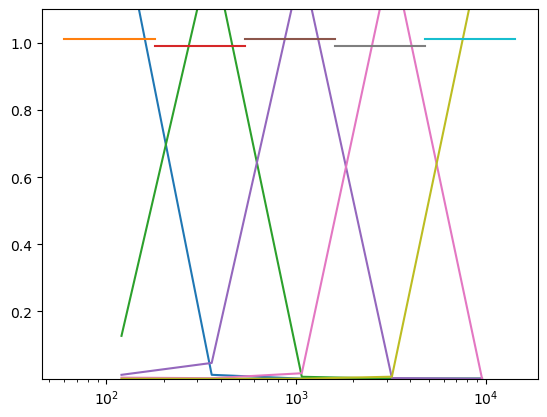

In [23]:
zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 2 # 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

In [61]:
tst_pk_nomask[0]

array([ 7.23045355e-13,  3.00226353e-11,  7.16469773e-12,  4.48364711e-11,
       -4.32292201e-12,  4.12972706e-13])

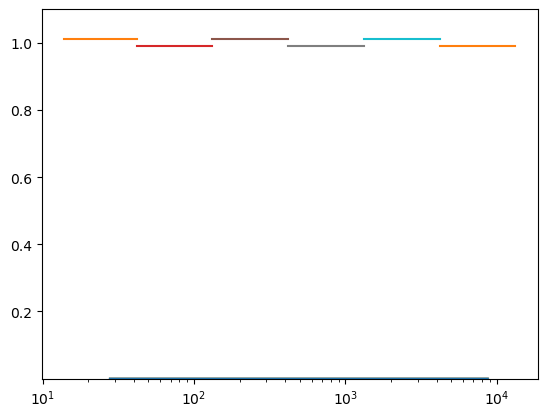

In [87]:
zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 2# 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

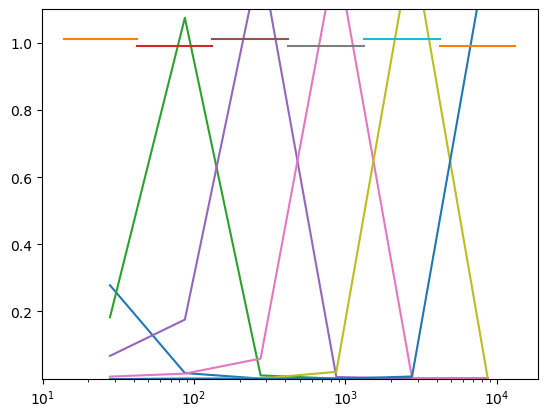

In [16]:
zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 2# 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

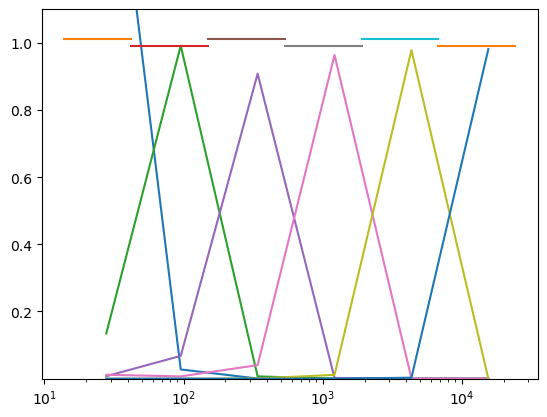

In [16]:
zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

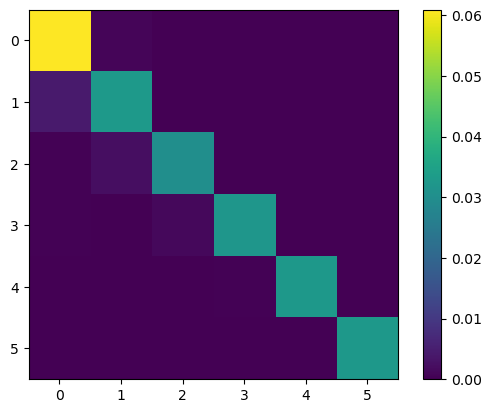

In [18]:
plt.imshow(tst_pk_nomask)
plt.colorbar()

In [19]:
fudge_factor

30.107912141639698

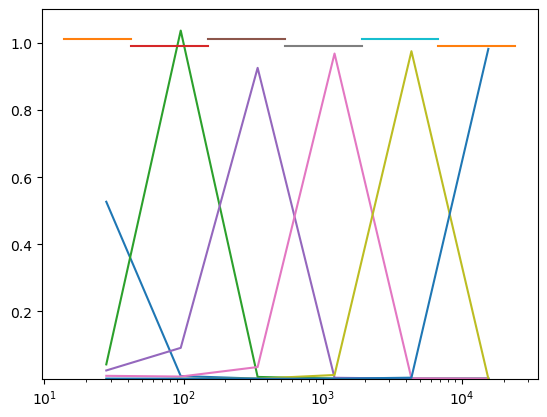

In [72]:
zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk_nomask[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

In [84]:
tst = np.random.randn(100,100)

In [85]:
tst

array([[-0.92286555,  2.26046255,  1.23830467, ...,  0.17350582,
         0.45486038,  1.64299571],
       [ 0.6733897 , -0.37666717,  0.11130954, ...,  0.19357561,
        -0.29603617,  0.02280055],
       [ 0.76920001,  0.04148063, -0.8263565 , ..., -1.30121165,
        -0.63890174, -0.95380184],
       ...,
       [-1.48866965, -0.7082146 , -0.55558602, ..., -1.1478547 ,
        -0.00652982,  2.50414669],
       [ 0.46380358,  0.24263858, -0.84010537, ...,  1.05401884,
        -0.59501492, -1.42122886],
       [-1.26623276, -0.9900236 , -0.47998066, ..., -0.72989412,
         0.11321017,  0.74379673]])

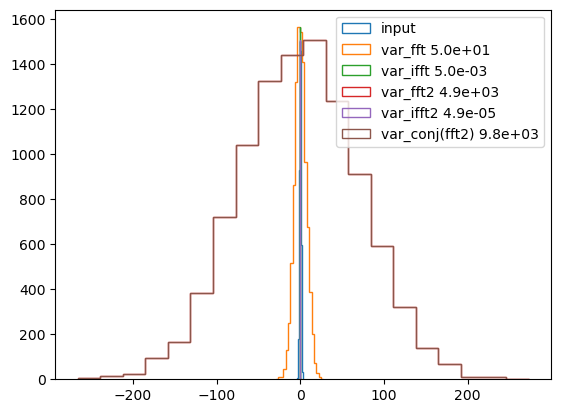

In [116]:
plt.hist(np.ravel(tst),bins=20, histtype='step',label='input');
plt.hist(np.ravel(np.real(np.fft.fft(tst))),bins=20, histtype='step',label='var_fft {0:0.1e}'.format(np.var(np.real(np.fft.fft(tst)))));
plt.hist(np.ravel(np.real(np.fft.ifft(tst))),bins=20, histtype='step',label='var_ifft {0:0.1e}'.format(np.var(np.real(np.fft.ifft(tst)))));
plt.hist(np.ravel(np.real(np.fft.fft2(tst))),bins=20, histtype='step',label='var_fft2 {0:0.1e}'.format(np.var(np.real(np.fft.fft2(tst)))));
plt.hist(np.ravel(np.real(np.fft.ifft2(tst))),bins=20, histtype='step',label='var_ifft2 {0:0.1e}'.format(np.var(np.real(np.fft.ifft2(tst)))));
plt.hist(np.ravel(np.conj(np.fft.fft2(tst))),bins=20, histtype='step',label='var_conj(fft2) {0:0.1e}'.format(np.var(np.conj(np.fft.fft2(tst)))));
plt.legend();

In [126]:
np.real(np.fft.ifft2(tst))

array([[-2.15229260e-02,  6.71818628e-03,  3.87387899e-03, ...,
         5.99380473e-03,  3.87387899e-03,  6.71818628e-03],
       [-1.62277395e-02,  7.71455435e-03, -8.26100926e-03, ...,
         1.00285365e-02,  1.18820498e-02,  3.19569955e-03],
       [-1.52943535e-02,  8.33168664e-03, -9.41283396e-03, ...,
        -1.65937152e-02, -9.35808198e-03,  9.58095723e-03],
       ...,
       [ 4.46793783e-03,  4.05258888e-03,  8.26670181e-03, ...,
        -9.87534556e-04,  1.51675478e-03, -1.73798970e-04],
       [-1.52943535e-02,  9.58095723e-03, -9.35808198e-03, ...,
        -4.91046653e-05, -9.41283396e-03,  8.33168664e-03],
       [-1.62277395e-02,  3.19569955e-03,  1.18820498e-02, ...,
        -6.31445260e-03, -8.26100926e-03,  7.71455435e-03]])

In [20]:
sc.real(sc.fft.ifft2(tst))

NameError: name 'sc' is not defined

TypeError: 'module' object is not callable

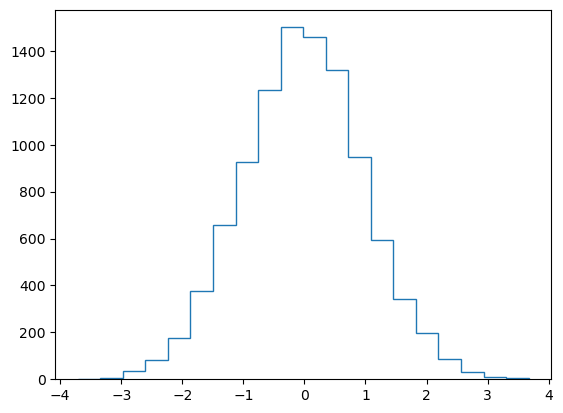

In [118]:
import scipy as sc
plt.hist(np.ravel(tst),bins=20, histtype='step',label='input');
plt.hist(np.ravel(np.real(sc.fft(tst))),bins=20, histtype='step',label='var_fft {0:0.1e}'.format(np.var(np.real(sc.fft(tst)))));
plt.legend();

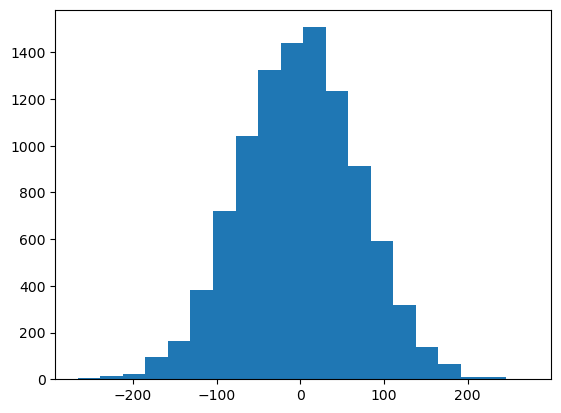

In [94]:
plt.hist(np.ravel(np.real(np.fft.fft2(tst))),bins=20);

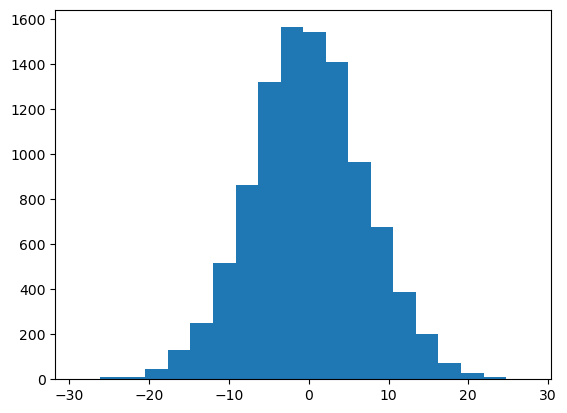

In [95]:
plt.hist(np.ravel(np.real(np.fft.fft(tst))),bins=20);